**2D nonlinear diffusion-reaction system**

In [25]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

seed = 42
batch_size = 100
noise_scale = 0.01  # Standard deviation of the noise
num_samples = 100
num_sensors = 100

np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 2
        self.numParams = 1
        self.numOutputs = 2
        self.hidden_size = 25

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.predicted_params = torch.zeros((batch_size,self.numParams), requires_grad=True, device=self.device)

        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)

        
    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(self.device)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y).float().to(self.device)

        input = torch.cat((x, y), 1)
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        prior_param_sample = torch.rand(batch_size, self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        output = self.b3(torch.multiply(t2, h2))

        # Split the output into u and f, each of shape [100]
        u = output[:, 0]  
        f = output[:, 1]

        return u, f



    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)



    def PDE_residual(self, x, y, lambd=0.01):
        u, f = self.forward(x, y)
        du_dx = self.compute_derivative(u, x, 1)
        du_dy = self.compute_derivative(u, y, 1)
        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)
        
        # residual = lambda(d2u_dx2 + d2u_dy2) + k * (u**2) + f
        residual = lambd(d2u_dx2 + d2u_dy2) + torch.multiply(self.predicted_params[:,[0]], u ** 2) + f

        return residual


In [26]:
# exact solution
def exact_solution(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

# function f
def source_term(x, y, lambd=0.01, k=1.0):
    u = exact_solution(x, y)
    f = -1/50.0 * torch.pi**2 * (u) + u**2
    return f


In [27]:
def plot_u_f_distribution(x_grid, y_grid, u, f, sensor_x, sensor_y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Subplot for 'u'
    contour1 = axes[0].contourf(x_grid.numpy(), y_grid.numpy(), u.numpy(), cmap='jet', levels=40, vmin=-1, vmax=1)
    scatter_u = axes[0].scatter(sensor_x.numpy(), sensor_y.numpy(), cmap='jet', facecolors='none', marker='o', edgecolor='black', s=40, linewidths=2, label="training sample for u")
    fig.colorbar(contour1, ax=axes[0])
    axes[0].set_title('Distribution of u')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    # Subplot for 'f'
    contour2 = axes[1].contourf(x_grid.numpy(), y_grid.numpy(), f.numpy(), cmap='jet', levels=40, vmin=0, vmax=1)
    scatter_f = axes[1].scatter(sensor_x.numpy(), sensor_y.numpy(),  cmap='jet', color='black', marker='x', s=40, linewidths=2, label="training sample for s")
    fig.colorbar(contour2, ax=axes[1])
    axes[1].set_title('Distribution of f')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

In [28]:
def sample_dataset_nonlinear(noise_scale=0.01, num_samples=100, device='cpu', lambd=0.01, k=0.5):    
    x = torch.linspace(-1, 1, num_samples, device=device) # Space domain for x
    y = torch.linspace(-1, 1, num_samples, device=device) # Space domain for y
    
    # Create a 2D grid of x and y values
    x_grid, y_grid = torch.meshgrid(x, y, indexing="ij")

    u = exact_solution(x_grid, y_grid)
    f = source_term(x_grid, y_grid)

    # Generate random sensor locations
    indices = np.random.choice(x_grid.numel(), num_sensors, replace=False)
    sensor_x = x_grid.reshape(-1)[indices]
    sensor_y = y_grid.reshape(-1)[indices]

    # Extracting sensor values for u and f
    sensor_u = u.reshape(-1)[indices]
    sensor_f = f.reshape(-1)[indices]
    
    plot_u_f_distribution(x_grid, y_grid, u, f, sensor_x, sensor_y)

    return x, y, sensor_u, sensor_f 

In [29]:
def create_train_dataset(device='cpu', batch_size=batch_size):
    # Generate the data
    x_train, y_train, sensor_u, sensor_f = sample_dataset_nonlinear(num_samples)

    # Add Gaussian noise to sensor data
    sensor_u_noisy = sensor_u + torch.randn(sensor_u.size()) * noise_scale
    sensor_f_noisy = sensor_f + torch.randn(sensor_f.size()) * noise_scale
    
    train_dataset = TensorDataset(x_train, y_train, sensor_u_noisy, sensor_f)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return sensor_x, sensor_y, sensor_u_noisy, sensor_f_noisy

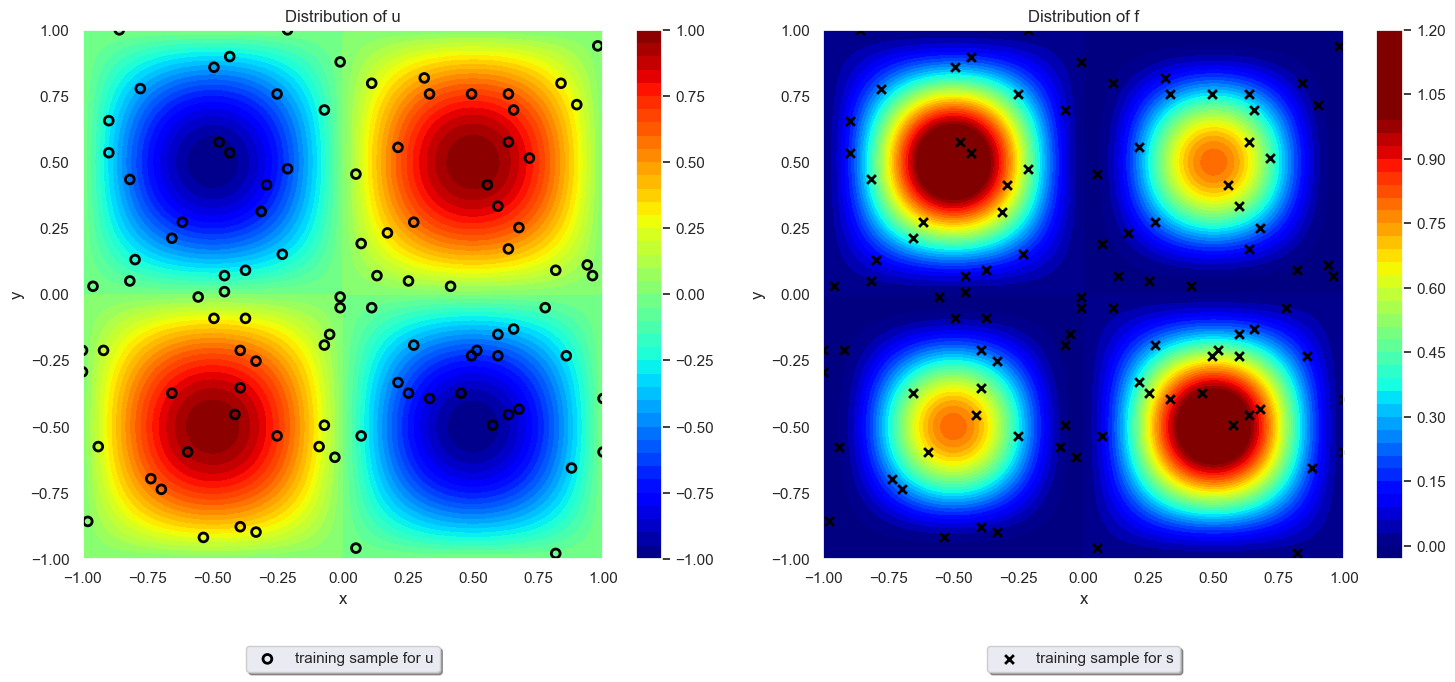

In [30]:
sensor_x, sensor_y, sensor_u_noisy, sensor_f_noisy = create_train_dataset()

In [6]:
model = Experiment()
model.to(model.device)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

mps
Params: 2103


In [327]:
model = Experiment()

x_samples = torch.linspace(-1, 1, steps=batch_size).unsqueeze(1)  
y_samples = torch.linspace(-1, 1, steps=batch_size).unsqueeze(1)  

x_samples = x_samples.to(model.device)
y_samples = y_samples.to(model.device)

x_samples = x_samples.repeat(1, batch_size // x_samples.size(0)).view(-1, 1)
y_samples = y_samples.repeat(1, batch_size // y_samples.size(0)).view(-1, 1)

u, f = model(x_samples, y_samples)  

print("Output u shape:", u.shape)
print("Output f shape:", f.shape)


mps
Output u shape: torch.Size([100])
Output f shape: torch.Size([100])


In [328]:
f

tensor([-0.0080,  0.0296,  0.0018,  0.0060,  0.0053,  0.0191,  0.0211,  0.0103,
         0.0171,  0.0081, -0.0039, -0.0121, -0.0108,  0.0128,  0.0124, -0.0029,
         0.0045, -0.0006, -0.0125,  0.0109,  0.0008, -0.0089,  0.0039, -0.0122,
        -0.0162, -0.0037,  0.0015,  0.0182, -0.0142,  0.0113,  0.0090, -0.0169,
         0.0020,  0.0307,  0.0166,  0.0098,  0.0224,  0.0022,  0.0050,  0.0271,
         0.0208, -0.0010, -0.0095, -0.0112,  0.0040,  0.0078,  0.0023,  0.0037,
         0.0178,  0.0041,  0.0125,  0.0123,  0.0058, -0.0206,  0.0025,  0.0121,
         0.0041,  0.0109,  0.0174,  0.0148, -0.0058,  0.0162,  0.0005,  0.0137,
         0.0019,  0.0164,  0.0189,  0.0143,  0.0098,  0.0112, -0.0019, -0.0013,
        -0.0094,  0.0016, -0.0163,  0.0002, -0.0019,  0.0018,  0.0081,  0.0170,
         0.0065,  0.0091,  0.0045, -0.0154,  0.0069,  0.0082,  0.0058, -0.0002,
         0.0111,  0.0127,  0.0109,  0.0138, -0.0270,  0.0116,  0.0074,  0.0113,
         0.0147, -0.0114,  0.0102,  0.01